In [1]:
%cd ..

/mnt/c/Users/jarek/Desktop/lauzhack-ecompute


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import *
from matplotlib import pyplot as plt
from src import dataloader, scheduler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.linear_model import LogisticRegression

In [67]:
data = dataloader.load_data()
data = data.sort_index()
data = scheduler.add_time_chunk_classification(data)
data = data.fillna(0)
data

Time,Hydro pumped storage consumption,Import Balance,Nuclear,Hydro Run-of-River,Biomass,Fossil brown coal / lignite,Fossil hard coal,Fossil oil,Fossil gas,Geothermal,...,Solar,Load,Residual load,Renewable share of generation,Renewable share of load,Overproduction,Percentage Renewable,Percentage Fossil,Green,Grey
2022-01-03 00:00:00+01:00,-2718.4,-8918.5,3326.2,1807.1,4538.0,4249.5,1839.4,112.4,2786.4,21.2,...,0.0,44302.8,4593.3,75.2,89.6,True,0.658653,0.341347,False,False
2022-01-03 00:15:00+01:00,-2776.0,-8261.5,3324.3,1805.9,4556.3,4258.4,1838.8,112.4,2772.9,21.3,...,0.0,43763.5,5039.4,74.7,88.5,True,0.651892,0.348108,False,False
2022-01-03 00:30:00+01:00,-2734.1,-8184.3,3249.1,1806.2,4558.8,4207.3,1830.8,112.4,2771.3,21.4,...,0.0,43604.5,5575.4,74.6,87.2,True,0.648786,0.351214,False,False
2022-01-03 00:45:00+01:00,-2840.4,-8611.1,3185.5,1805.6,4543.2,4142.9,1824.8,112.4,2806.1,21.5,...,0.0,43036.2,3372.5,75.6,92.2,True,0.660944,0.339056,False,False
2022-01-03 01:00:00+01:00,-2680.6,-8400.3,3164.6,1808.1,4541.5,4110.0,1804.9,112.4,2821.9,21.5,...,0.0,42723.7,3374.5,75.4,92.1,True,0.660283,0.339717,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27 22:45:00+01:00,-1914.9,-11020.6,3861.0,1408.9,5162.4,13210.1,7894.3,3.3,3809.9,18.7,...,0.0,46929.6,17375.8,50.1,63.0,True,0.405315,0.594685,False,False
2022-11-27 23:00:00+01:00,-2423.8,-10003.0,3804.9,1404.5,5154.1,13295.4,7246.3,3.3,3808.0,18.7,...,0.0,46415.1,16984.8,50.6,63.4,True,0.411439,0.588561,False,False
2022-11-27 23:15:00+01:00,-2514.7,-9939.5,3712.2,1390.5,5139.4,13410.6,6987.1,3.3,3727.9,18.7,...,0.0,45799.3,16297.8,50.9,64.4,True,0.414878,0.585122,False,False
2022-11-27 23:30:00+01:00,-2990.4,-9862.7,3687.7,1394.3,5143.4,13582.9,6895.1,3.3,3697.9,18.7,...,0.0,44600.5,14874.9,51.1,66.6,True,0.416770,0.583230,False,False


In [68]:
weather = pd.read_csv(os.path.join('data', 'weather.csv'), index_col=0)
weather = weather.sort_index()
weather['datetime'] = (pd.DatetimeIndex(weather['datetime']) + pd.Timedelta(-1, unit='hours')).tz_localize('UTC').tz_convert('CET')
weather = weather.set_index('datetime')
weather = pd.concat((weather, pd.get_dummies(weather['condition'])), axis=1).drop('condition', axis=1)
weather = weather.fillna(0)
weather

,wind_speed,sunshine,cloud_cover,temperature,wind_gust_speed,dry,rain,sleet,snow
datetime,,,,,,,,,
2022-01-01 00:00:00+01:00,19.8,0.0,100.0,11.9,36.4,0,1,0,0
2022-01-01 01:00:00+01:00,18.4,0.0,100.0,11.9,34.9,0,1,0,0
2022-01-01 02:00:00+01:00,19.4,0.0,100.0,11.9,36.0,0,1,0,0
2022-01-01 03:00:00+01:00,21.6,0.0,100.0,11.9,34.9,0,1,0,0
2022-01-01 04:00:00+01:00,18.0,0.0,87.0,11.8,33.8,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2022-12-02 20:00:00+01:00,18.7,0.0,100.0,-0.8,34.6,1,0,0,0
2022-12-02 21:00:00+01:00,20.2,0.0,100.0,-0.9,31.7,1,0,0,0
2022-12-02 22:00:00+01:00,19.4,0.0,100.0,-1.1,28.8,1,0,0,0


In [87]:
ultimate_data = weather.merge(data, how='inner', left_index=True, right_index=True)
ultimate_data

,wind_speed,sunshine,cloud_cover,temperature,wind_gust_speed,dry,rain,sleet,snow,Hydro pumped storage consumption,...,Solar,Load,Residual load,Renewable share of generation,Renewable share of load,Overproduction,Percentage Renewable,Percentage Fossil,Green,Grey
2022-01-03 00:00:00+01:00,13.0,0.0,87.0,9.7,22.3,1,0,0,0,-2718.4,...,0.0,44302.8,4593.3,75.2,89.6,True,0.658653,0.341347,False,False
2022-01-03 01:00:00+01:00,14.8,0.0,100.0,10.0,27.7,0,1,0,0,-2680.6,...,0.0,42723.7,3374.5,75.4,92.1,True,0.660283,0.339717,False,False
2022-01-03 02:00:00+01:00,16.9,0.0,100.0,9.3,33.5,0,1,0,0,-2689.5,...,0.0,42982.6,6362.7,74.2,85.2,True,0.642785,0.357215,False,False
2022-01-03 03:00:00+01:00,17.3,0.0,87.0,8.9,33.1,0,1,0,0,-2343.1,...,0.0,43904.2,5752.6,75.0,86.9,True,0.652478,0.347522,False,False
2022-01-03 04:00:00+01:00,17.6,0.0,87.0,9.1,38.2,0,1,0,0,-1342.2,...,0.0,47251.1,5533.9,75.9,88.3,True,0.669029,0.330971,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27 19:00:00+01:00,13.3,0.0,100.0,5.4,22.0,1,0,0,0,-94.1,...,0.0,53205.0,24453.9,46.0,54.0,True,0.393892,0.606108,False,False
2022-11-27 20:00:00+01:00,14.0,0.0,100.0,4.8,22.3,1,0,0,0,-5.8,...,0.0,50449.7,21207.0,48.4,58.0,True,0.402323,0.597677,False,False
2022-11-27 21:00:00+01:00,14.0,0.0,100.0,4.7,23.8,1,0,0,0,-114.1,...,0.0,50328.2,21187.2,48.8,57.9,True,0.397120,0.602880,False,False
2022-11-27 22:00:00+01:00,14.4,0.0,100.0,4.7,24.5,1,0,0,0,-657.0,...,0.0,49070.4,19573.8,49.4,60.1,True,0.403077,0.596923,False,False


In [210]:
week_delta = pd.Timedelta(7, unit='days')
prediction_delta = pd.Timedelta(3, unit='days')

def make_data(ultimate_data):
    # Assumes equidistant samplings    
    X, y = [], []
    for date in ultimate_data.index:
        if date + week_delta + prediction_delta not in ultimate_data.index:
            continue
        X.append(ultimate_data.loc[date:date+week_delta].to_numpy().T.ravel())
        y.append(ultimate_data.loc[date+week_delta+prediction_delta,'Overproduction'])
    return np.vstack(X), np.hstack(y)

In [201]:
X, y = make_data(ultimate_data)
X = PCA(whiten=True, n_components=20).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [202]:
from sklearn.svm import SVC

In [203]:
model = SVC()
model.fit(X_train, y_train)

SVC()

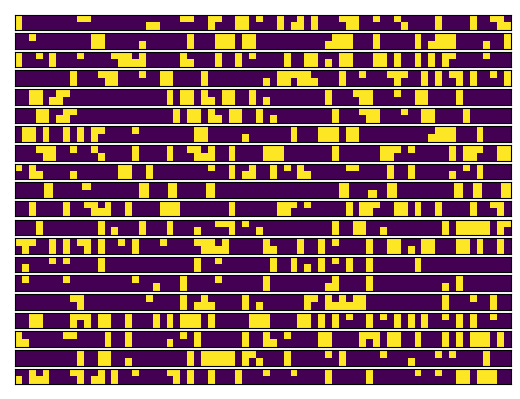

In [204]:
from random import randint

fig, axes = plt.subplots(nrows=20)
for i, ax in enumerate(axes):
    idx = randint(0, len(X_test))
    ax.matshow(np.vstack((y_test[idx:idx+24*3], model.predict(X_test)[idx:idx+24*3])))
    ax.set(yticks=[], xticks=[], aspect='auto')

In [205]:
from sklearn.metrics import f1_score
print(model.score(X_test, y_test))
print(f1_score(y_test, model.predict(X_test)))

0.8834900731452455
0.7857829010566763


In [207]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [218]:
prediction = pd.Series(model.predict(X))
prediction.index = ultimate_data.loc[:ultimate_data.index[-1] - (week_delta + prediction_delta)].index + week_delta + prediction_delta
prediction

2022-01-13 00:00:00+01:00     True
2022-01-13 01:00:00+01:00     True
2022-01-13 02:00:00+01:00     True
2022-01-13 03:00:00+01:00     True
2022-01-13 04:00:00+01:00     True
                             ...  
2022-11-27 19:00:00+01:00    False
2022-11-27 20:00:00+01:00    False
2022-11-27 21:00:00+01:00     True
2022-11-27 22:00:00+01:00     True
2022-11-27 23:00:00+01:00     True
Length: 7656, dtype: bool

In [220]:
with open('prediction.csv', 'w+') as f:
    f.write(prediction.to_csv())